In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from sklearn.model_selection import train_test_split as tts

In [6]:
df = pd.read_csv('C://Users//hasan//OneDrive//Desktop//DS//seri4//emtiazy//A_Z Handwritten Data.csv')

In [7]:
X = df.drop('0',axis=1)
y = df['0']
X = X / 255.0
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.30, random_state=42)

In [8]:
import numpy as np 
from scipy._lib._util import check_random_state


def projection_simplex(v, z=1):
    """
    Projection onto the simplex:
        w^* = argmin_w 0.5 ||w-v||^2 s.t. \sum_i w_i = z, w_i >= 0
    """
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w

In [9]:
class SVM():

    def __init__(self, C=1, max_iter=50, tol=0.05,
                 random_state=None, verbose=0):
        self.C = C
        self.max_iter = max_iter
        self.tol = tol,
        self.random_state = random_state
        self.verbose = verbose

    def _partial_gradient(self, X, y, i):
        # Partial gradient for the ith sample.
        g = np.dot(X[i], self.coef_.T) + 1
        g[y[i]] -= 1
        return g

    def _violation(self, g, y, i):
        # Optimality violation for the ith sample.
        smallest = np.inf
        for k in range(g.shape[0]):
            if k == y[i] and self.dual_coef_[k, i] >= self.C:
                continue
            elif k != y[i] and self.dual_coef_[k, i] >= 0:
                continue

            smallest = min(smallest, g[k])

        return g.max() - smallest

    def _solve_subproblem(self, g, y, norms, i):
        # Prepare inputs to the projection.
        Ci = np.zeros(g.shape[0])
        Ci[y[i]] = self.C
        beta_hat = norms[i] * (Ci - self.dual_coef_[:, i]) + g / norms[i]
        z = self.C * norms[i]

        # Compute projection onto the simplex.
        beta = projection_simplex(beta_hat, z)

        return Ci - self.dual_coef_[:, i] - beta / norms[i]

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize primal and dual coefficients.
        n_classes = len(np.unique(y))
        self.dual_coef_ = np.zeros((n_classes, n_samples), dtype=np.float64)
        self.coef_ = np.zeros((n_classes, n_features))

        # Pre-compute norms.
        norms = np.sqrt(np.sum(X ** 2, axis=1))

        # Shuffle sample indices.
        rs = check_random_state(self.random_state)
        ind = np.arange(n_samples)
        rs.shuffle(ind)

        violation_init = None
        for it in range(self.max_iter):
            violation_sum = 0

            for ii in range(n_samples):
                i = ind[ii]

                # All-zero samples can be safely ignored.
                if norms[i] == 0:
                    continue

                g = self._partial_gradient(X, y, i)
                v = self._violation(g, y, i)
                violation_sum += v

                if v < 1e-12:
                    continue

                # Solve subproblem for the ith sample.
                delta = self._solve_subproblem(g, y, norms, i)

                # Update primal and dual coefficients.
                self.coef_ += (delta * X[i][:, np.newaxis]).T
                self.dual_coef_[:, i] += delta

            if it == 0:
                violation_init = violation_sum

            vratio = violation_sum / violation_init

            if self.verbose >= 1:
                print("iter", it + 1, "violation", vratio)

            if vratio < self.tol:
                if self.verbose >= 1:
                    print("Converged")
                break

        return self
    
    def predict(self, X):
        decision = np.dot(X, self.coef_.T)
        pred = decision.argmax(axis=1)
        return pred
        

In [10]:
clf = SVM(max_iter = 10, verbose = 1)

In [11]:
clf.fit(X_train, y_train)

iter 1 violation 1.0
iter 2 violation 1.0184591222369679
iter 3 violation 0.9877834080988307
iter 4 violation 0.9802551160206296
iter 5 violation 0.976784244413639
iter 6 violation 0.9747834175527873
iter 7 violation 0.9730511233832123
iter 8 violation 0.9712937801668386
iter 9 violation 0.9702965700326388
iter 10 violation 0.9684635703283885


In [12]:
from sklearn.metrics import accuracy_score

preds = clf.predict(X_test)
print('accuracy = ', accuracy_score(preds, y_test) * 100, '%')

accuracy =  76.8362643755314 %


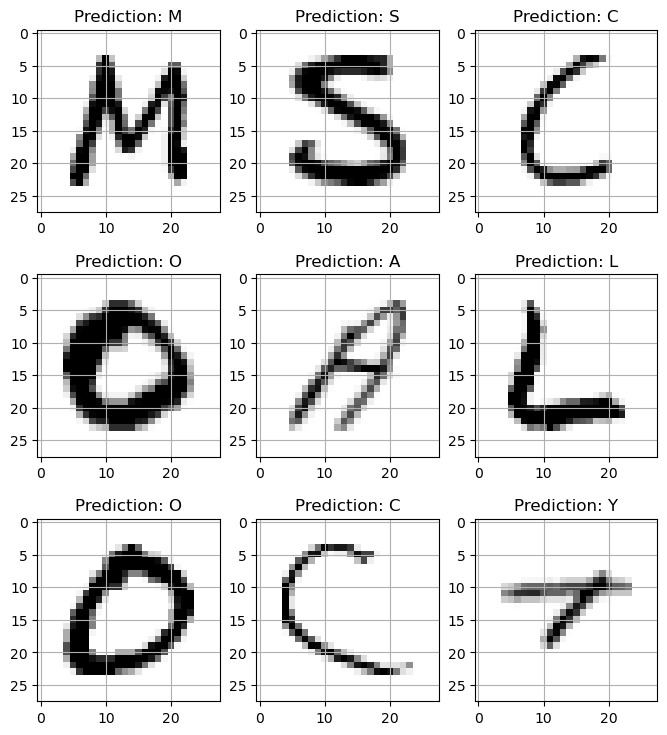

In [16]:
word_dict = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


fig, axes = plt.subplots(3, 3, figsize=(8, 9))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img = np.reshape(X_test[i], (28, 28))
    ax.imshow(img, cmap="Greys")
    
    # Assuming 'clf' is your SVM model and 'word_dict' contains label mappings
    pred_label = clf.predict([X_test[i]])[0]
    pred = word_dict[pred_label]
    
    ax.set_title("Prediction: " + pred)
    ax.grid()

plt.show()
